## FUNCIONES

In [3]:
from cryptography.fernet import Fernet
import pandas as pd
from sqlalchemy import create_engine
import json
import requests
import numpy as np
from scipy.optimize import minimize
import math 
from HorariosReservas import horariosReservas # Asegúrate de tener esta importación para math.ceil
from Global import Reserva
import matplotlib.pyplot as plt
from QueryReservasxHora import generarQuery
# Function to generate and encrypt credentials

def create_encrypted_credentials(filename='db_credentials.enc'):
    credentials = {
        'server': '190.210.150.90,1433',
        'database': 'rapiboyv7',
        'username': 'gastonMichelotti',
        'password': 'e4c9b81800490aab2c7ece08018853f23ac75e08ecb7725a6d6cb496539b3fe1',
        'driver': 'ODBC Driver 17 for SQL Server',
        'port': '1433'
    }

    # Generate a key and save it for decryption
    key = Fernet.generate_key()
    with open('encryption_key.key', 'wb') as key_file:
        key_file.write(key)

    fernet = Fernet(key)
    encrypted_credentials = fernet.encrypt(json.dumps(credentials).encode())

    # Write encrypted credentials to a file
    with open(filename, 'wb') as file:
        file.write(encrypted_credentials)

def load_credentials(filename='db_credentials.enc', key_file='encryption_key.key'):
    # Load the key
    with open(key_file, 'rb') as file:
        key = file.read()

    fernet = Fernet(key)

    # Read and decrypt the credentials
    with open(filename, 'rb') as file:
        encrypted_credentials = file.read()

    decrypted_credentials = fernet.decrypt(encrypted_credentials)
    credentials = json.loads(decrypted_credentials.decode())

    return credentials

def consultaDB(query):
    # Cargar las credenciales desde el archivo encriptado
    credentials = load_credentials()

    server = credentials['server']
    database = credentials['database']
    username = credentials['username']
    password = credentials['password']
    driver = credentials['driver']
    port = credentials['port']

    # Formulate the connection string for SQLAlchemy with pyodbc
    conn = f"mssql+pyodbc://{username}:{password}@{server}:{port}/{database}?driver={driver}"

    # Create an SQLAlchemy engine
    engine = create_engine(conn)
    
    # Ejecutar la consulta y devolver el resultado
    result = pd.read_sql(query, engine)

    return result

def obtener_forecast(fecha):
    url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTqP8Cc8coM8EqPpAHDiRtyX2sxd1gokCUCbR8erhVrs7O9hXXbW0oruGaZIDtXYvLAztNoLG645L0I/pub?output=csv"
    response = requests.get(url)
    assert response.status_code == 200, 'Error al descargar los datos'
    df = pd.read_csv(url)
    
    columna_fecha = None
    for col in df.columns:
        if df[col].iloc[0] == fecha:
            columna_fecha = col
            break
    
    if columna_fecha is None:
        raise ValueError(f"No se encontró la fecha {fecha}")
    
    valoresMeli = [int(valor) for valor in df[columna_fecha].dropna().tolist() if valor.isdigit()]

    # Crear el rango de horarios desde 8:00 am hasta 00:30 am en tramos de 30 minutos
    horarios = [8 + i * 0.5 for i in range(len(valoresMeli))]

    # Crear el diccionario combinando los horarios y los valores
    forecast_dict = dict(zip(horarios, valoresMeli))

    return forecast_dict

def calcular_disponibilidad(configuracion, horarios):
    # Configuración debe coincidir en largo con horariosReservas
    reservas = [Reserva(horariosReservas[i][0], horariosReservas[i][1]) 
                for i, cantidad in enumerate(configuracion) for _ in range(round(cantidad))]

    # Crear un diccionario donde la clave es el horario y el valor es la disponibilidad
    disponibilidad = {
        hora: sum(1 for reserva in reservas if reserva.horaDesde <= hora and reserva.horaHasta > hora)
        for hora in horarios
    }

    return disponibilidad

def convertir_horas(value):
        
        #Convierto formato de horas de numero a string fixeando horarios 24 a horarios 00
        hours = int(value) if int(value) < 24 else int(value) - 24  # Parte entera para las hora
        minutes = int(((value - hours) * 60 if hours > 1 
                       else ( (value - 25) if hours == 1 
                       else (value - 24)) * 60))  # Parte decimal convertida a minutos
        
        # Formatear como HH:MM
        time_string = f"{hours:02d}:{minutes:02d}"
        
        return time_string

def agregar_turno(data, cantidad, hora_desde, hora_hasta):
    nuevo_turno = {
        "cantidad": cantidad,
        "horaDesde": hora_desde,
        "horaHasta": hora_hasta
    }
    data["turnos"].append(nuevo_turno)

    # Ejemplo de uso, puedes agregar tantos turnos como desees
    # agregar_turno(final, 100, "19:00", "00:00")
    # agregar_turno(final, 100, "19:00", "23:00")

def graficar_resultados(disponibilidadFinal, valoresMeli, reales, desde = 8, hasta = 1.5):

    ### DisponibilidadFinal, valoresMeli deben ser disponibilidades en forma de diccionario y deben coincidir(?)
    ### reales debe ser solo el resutlado de la query (que ya es una disponibilidad.)
    if hasta < 5:
        hasta = hasta + 24

    horarios = [f"{int(hora):02d}:{int((hora - int(hora)) * 60):02d}" for hora in np.arange(desde, hasta, 0.5)]

    disponibilidadCargada = reales['TotalReservas']
    disponibilidadLlegada = reales['ReservasConLlegada']

    plt.figure(figsize=(15, 7))
    plt.plot(horarios, valoresMeli.values(), label='Repartidores Solicitados por Meli', marker='D', color = 'green')
    plt.plot(horarios, disponibilidadFinal.values() , label='Disponibilidad Repartidores estimador', marker='o', color = '#0576ff')
    plt.plot(horarios, disponibilidadCargada, label='Reservas Cargados ', marker='*', color = 'red')
    plt.plot(horarios, disponibilidadLlegada, label='Reservas tomadas ', marker='*', color = 'purple')
    plt.title('Disponibilidad vs. Solicitudes de Repartidores por Hora')
    plt.xlabel('Hora del Día')
    plt.ylabel('Cantidad de Repartidores')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def estimar_simple(fecha, 
            horario_desde=8, 
            horario_hasta=1.5,
            incremento_previo_meli=0, 
            incremento_previo_meli_desde=0,
            incremento_previo_meli_hasta=0,
            incremento_posterior_general=0):
    
    if horario_hasta < 5:
        horario_hasta = horario_hasta + 24

    horarios = np.arange(horario_desde, horario_hasta, 0.5)    
    
    # Obtenemos los requerimientos simples y sin procesar de meli y luego les aplicamos pre procesamiento según params.
    valoresMeli = obtener_forecast(fecha)

    valoresMeliIncrementados = valoresMeli
    
    if incremento_previo_meli > 0:
        factor_aumento = 1 + (incremento_previo_meli / 100)
        valoresMeliIncrementados = {
            horario: (math.ceil(valor * factor_aumento) if incremento_previo_meli_desde <= horario <= incremento_previo_meli_hasta else valor)
            for horario, valor in valoresMeli.items()
        }

    def objetivo(config):
        valoresMeliIncrementados_array = [valoresMeliIncrementados[horario] for horario in sorted(valoresMeliIncrementados.keys())]
        disponibilidad = calcular_disponibilidad(config, horarios)
        disponibilidad_array = [disponibilidad[horario] for horario in sorted(disponibilidad.keys())]

        if len(valoresMeliIncrementados_array) != len(disponibilidad_array):
            print('Valores Meli Incrementados:', valoresMeliIncrementados_array)
            print('Len Valores Meli Incr.:', len(valoresMeliIncrementados_array))
            print('Disponibilidad:', disponibilidad_array)
            print('Len Disponibilidad:', len(disponibilidad_array))
            raise ValueError("Error: diferentes largos entre listas de disponibilidad meli-rapiboy")

        return sum((rm - rd)**2 for rm, rd in zip(valoresMeliIncrementados_array, disponibilidad_array)) + sum(config)

    valores_iniciales = [valoresMeliIncrementados[int(horarios[0])] * 2] * len(horariosReservas)
    bounds = [(0, None) for _ in range(len(valores_iniciales))]
    bounds[0] = (valoresMeliIncrementados[int(horarios[0])], None)

    resultado_optimizacion = minimize(objetivo, valores_iniciales, method='Powell', bounds=bounds) 
    configuracionOptima = [int(x) for x in resultado_optimizacion.x]

    if incremento_posterior_general != 0:
        configuracionIncrementada = [math.ceil(x + x * incremento_posterior_general / 100) for x in configuracionOptima]
    else:
        configuracionIncrementada = configuracionOptima
        
    Resultados = [{'horaDesde': convertir_horas(horariosReservas[i][0]), 'horaHasta': convertir_horas(horariosReservas[i][1]), 'cantidad': configuracionIncrementada[i]} for i in range(len(horariosReservas))]

    disponibilidadFinal = calcular_disponibilidad(configuracionIncrementada, horarios)

    final = {
        "fecha": fecha,
        "horario_desde": horario_desde,
        "horario_hasta": horario_hasta,
        "turnos": [
            {
                "horaDesde": turno["horaDesde"],
                "horaHasta": turno["horaHasta"],
                "cantidad": turno["cantidad"]
            }
            for turno in Resultados
            ]
        }

    # También puedes devolver el JSON si es parte de una función
    return json.dumps(final, indent=4, ensure_ascii=False), disponibilidadFinal, valoresMeli

def probar_estimar_simple(fecha, 
            horario_desde= 8, 
            horario_hasta= 1.5,
            incremento_previo_meli=0, 
            incremento_previo_meli_desde=0,
            incremento_previo_meli_hasta=0,
            incremento_posterior_general=0):

    estimacion, dispoFinal, valoresMeli = estimar_simple(fecha, 
                                                        horario_desde,
                                                        horario_hasta, 
                                                        incremento_previo_meli,
                                                        incremento_previo_meli_desde,
                                                        incremento_previo_meli_hasta,
                                                        incremento_posterior_general)

    reales = consultaDB(generarQuery(fecha))

    print('ESTIMACION: ', estimacion)
    print('DISP. FINAL: ', dispoFinal)
    print('FORECAST MELI: ', valoresMeli)

    graficar_resultados(dispoFinal, valoresMeli, reales)



ESTIMACION:  {
    "fecha": "2/10/2024",
    "horario_desde": 8,
    "horario_hasta": 25.5,
    "turnos": [
        {
            "horaDesde": "08:00",
            "horaHasta": "11:00",
            "cantidad": 9
        },
        {
            "horaDesde": "08:00",
            "horaHasta": "12:00",
            "cantidad": 0
        },
        {
            "horaDesde": "08:30",
            "horaHasta": "11:30",
            "cantidad": 0
        },
        {
            "horaDesde": "09:00",
            "horaHasta": "12:00",
            "cantidad": 0
        },
        {
            "horaDesde": "09:00",
            "horaHasta": "13:00",
            "cantidad": 2
        },
        {
            "horaDesde": "10:00",
            "horaHasta": "12:00",
            "cantidad": 0
        },
        {
            "horaDesde": "10:00",
            "horaHasta": "13:00",
            "cantidad": 2
        },
        {
            "horaDesde": "10:00",
            "horaHasta": "14:00",
         

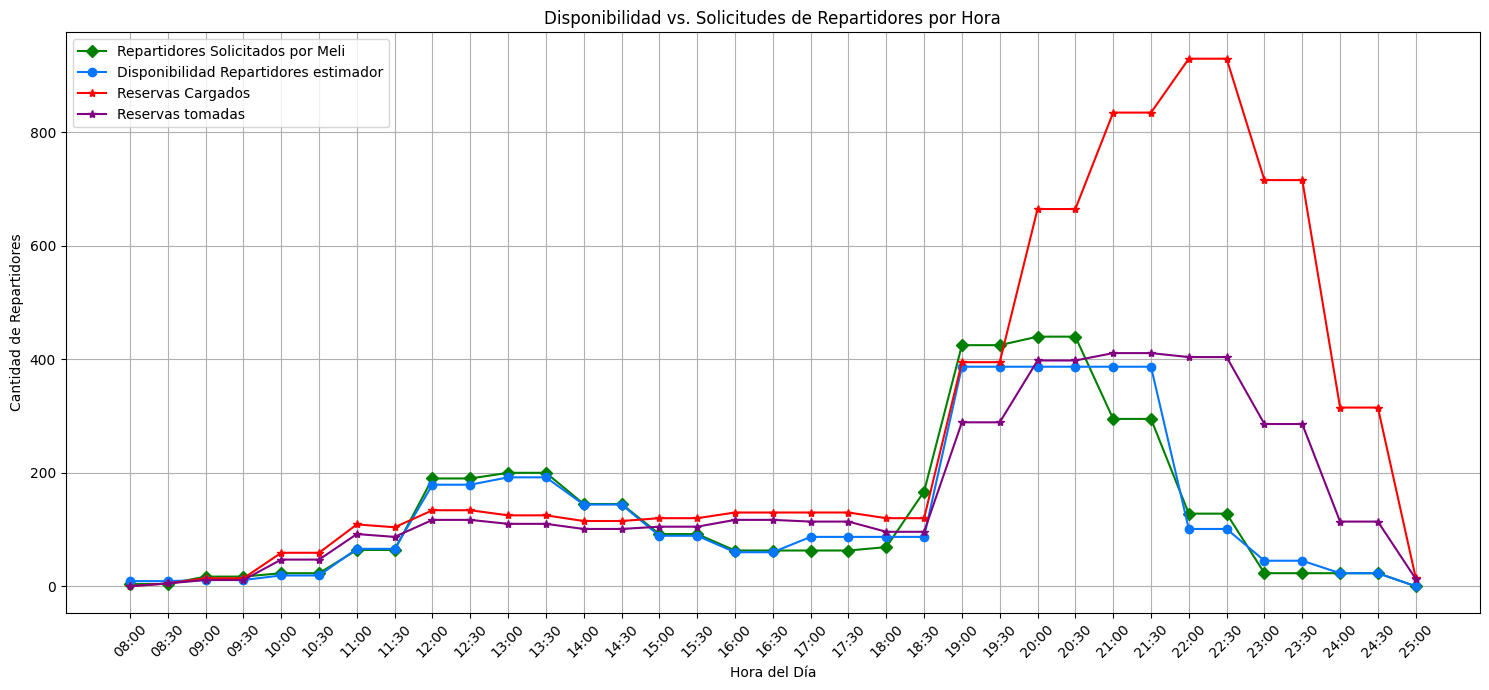

In [8]:
probar_estimar_simple('2/10/2024')


In [6]:
reales = consultaDB(generarQuery('2/10/2024'))


In [7]:
reales

,Fecha,Horario,TotalReservas,ReservasConLlegada
0,2024-10-02,08:00,0,0
1,2024-10-02,08:30,5,5
2,2024-10-02,09:00,14,11
3,2024-10-02,09:30,14,11
4,2024-10-02,10:00,59,47
5,2024-10-02,10:30,59,47
6,2024-10-02,11:00,109,92
7,2024-10-02,11:30,104,87
8,2024-10-02,12:00,134,117
9,2024-10-02,12:30,134,117
